## NYC Green Taxi

__Yi Li__

__This coding challenge is designed to test your skill and intuition about real world data. For the challenge, we will use data collected by the New York City Taxi and Limousine commission about “Green” Taxis. Green Taxis (as opposed to yellow ones) are taxis that are not allowed to pick up passengers inside of the densely populated areas of Manhattan. We will use the data from September 2015. We are using NYC Taxi and Limousine trip record data: (http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml).__


## Summary of Each Question

#### Question 1: Programmatically download and load into your favorite analytical tool the trip data for September 2015. Report how many rows and columns of data you have loaded.

_Number of rows: 1494926; Number of columns: 21_


#### Question 2: Plot a histogram of the number of the trip distance (“Trip Distance”). Report any structure you find and any hypotheses you have about that structure.

_When trip distance > 1 mile, as the trip distance increases, its count decreases; when trip distance < 1 mile, as the trip distance increases, its count increases. When 1 mile < trip distance < 40 miles, the relation between trip distance (TD) and its log(count) is almost linear. In other words, we can represent it as_ `$TD = b - a*log(count)$`.

_In reality, it makes sense that most taxi trips are short trips（aruound 1-2 miles). Becuase for long trips, it would be expensive to take a taxi, and people probably would choose public transportations like metro or bus to save their money. While for short trips, people probably prefer to choose taxi to save their time._


#### Question 3: Report mean and median trip distance grouped by hour of day.

_The median trip distance is always lower than the mean trip distance; the mean and median trip distances have similar trends, and we can separate the time into three parts:_
    _* trip distance appears to be the longest during 4am-7am;_
    _* trip distance appears to be the shortest during 7am-9pm;_
    _* trip distance appears to be medium during 9pm-4am._
    
#### We’d like to get a rough sense of identifying trips that originate or terminate at one of the NYC area airports. Can you provide a count of how many transactions fit this criteria, the average fare, and any other interesting characteristics of these trips.

_I choose the JFK airport with RateCodeID = 2. After removing suspicous records that seem wrong. I get the following results:_

_Number of transactions of trips that originate or terminate at JFK Airport: 3414. 
The average total amount of these transactions is: `$61.28`.
The fare amount of JFK trips is a fixed value: `$52`. 
The main cause of different total amount is tolls amount and tip amount. Then I checked whether the tip amount has something to do with the hour of a day. 
It is interesting that in most hours, the median of the tip amount is zero. 
One peak time of high tip amount is around 5:00-8:00, and the other peak time is around 14:00-15:00. We also find that 14:00-16:00 is the most rush hour of a day. So, people probably give high tips because of heavy traffic._

#### Question 4: Build a derived variable for tip as a percentage of the total fare. Build a predictive model for tip as a percentage of the total fare. Use as much of the data as you like (or all of it). Provide an estimate of performance using an appropriate sample, and show your work.

Define tip rate as the percentage of tip amount over the total amount. 

According to the [handbook](http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf), tip amount is automatically populated for credit card tips. Cash tips are not included. Thus, for this question, I choose to only use the trips paid by credit card to build the predictive model.

___Data Cleaning & Data Exploration:___

* Remove trips whose trip distance or trip duration or average trip speed is too large or negative; Remove trips whose total amount is less than the [initial charge](http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml) `$2.5`;

* Plot histograms and scatter plots to explore the relation between the features and the target trip rate.

* About `13.4%` of trips (paid by credit card) has zero tip.


___Feature Engineering:___

Create features like trip duration, average trip speed, trip pickup hour, etc. Since only the feature fare amount is time-and-distance based, I integrated the fares __EXCEPT FARE AMOUNT AND TIP AMOUNT__ into one variable called "other_amount".

___Models & Results:___

I split the oringal cleaned dataset into a training dataset and a test dataset (80% : 20%).

I first built a linear regression model as a benchmark. 
* The training results calculated by 10-fold cross validation: MAE: 5.44, RMSE: 7.35.
* The test results: MAE: 5.42, RMSE: 7.34.
* Tip rate has a positive correlation with trip distance and other amount (total amount - tip amount - fare amount). * Tip rate has a negative correlation with fare amount.


Then I built a regression random forest model and got better results.
* The training results calculated by 10-fold cross validation: MAE: 5.40, RMSE: 7.20.
* The test results: MAE: 5.37, RMSE: 7.18.
* Fare amount and other amount are the top 2 features affect tip rate in this regression random forest model, and this correspond with the results of the linear regression model.
* Duration, trip distance, and pickup hour also affect the trip rate.

Since the results of the regression random forest model is better, we should use this model to predict tip rate of trips.

** _If I have more time, I will probably try building an antoencoder (a neural network model) to see if I can get better results on this problem._

#### Question 5, Option A Distributions: Build a derived variable representing the average speed over the course of a trip. Can you perform a test to determine if the average trip speeds are materially the same in all weeks of September? If you decide they are not the same, can you form a hypothesis regarding why they differ?

_Define average speed over the course of a trip as Trip Distance/Trip Duration, and its unit is: mile per hour (mph)._

_From the density plot of the distributions of the verage trip speeds in each week, we can see that the average trip speeds of week 37, week 38 and week 40 are slightly slower than the ones of week 36 and week 39.The ANOVA test shows that the polulation mean of the average trip speed of these five weeks are significantly not the same._

_I checked [NYC historical weather in September 2015](https://www.timeanddate.com/weather/usa/new-york/historic?month=9&year=2015) and found that  it was raining on Sep.10th (in week 37) and Sep.30th (in week 40). This probably explains the reason why the average trip speeds in week 37 and week 40 are slightly slower than the ones in week 36 and week 39. I do not find any reasonable explanations why the average trip speed in week 38 is slow._


#### Can you build up a hypothesis of average trip speed as a function of time of day?

_The average trip speed during 21:00 - 7:00 is higher than the one during 7:00 - 21:00. I also used two-sample t-test to prove this._

In [1]:
## Environment: Python 3

## Import Packages
import os
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics 

import warnings
warnings.simplefilter(action='ignore')

#### Question 1

• Programmatically download and load into your favorite analytical tool the trip data for September 2015.

• Report how many rows and columns of data you have loaded.

In [2]:
## Download Data
if os.path.exists('green_tripdata_2015-09.csv'): # check if the file exists
    pass
else: # download
    url = 'https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv'
    response = urllib.request.urlopen(url)
    html = response.read()
    with open('green_tripdata_2015-09.csv', 'wb') as f:
        f.write(html)

In [3]:
## Load Data
data = pd.read_csv('green_tripdata_2015-09.csv')
print('Number of rows:', data.shape[0])
print('Number of columns:', data.shape[1])

Number of rows: 1494926
Number of columns: 21


In [4]:
## Explore data
print(data.columns)
print(data.head(3))
print(data.describe())

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge',
       'Total_amount', 'Payment_type', 'Trip_type '],
      dtype='object')
   VendorID lpep_pickup_datetime Lpep_dropoff_datetime Store_and_fwd_flag  \
0         2  2015-09-01 00:02:34   2015-09-01 00:02:38                  N   
1         2  2015-09-01 00:04:20   2015-09-01 00:04:24                  N   
2         2  2015-09-01 00:01:50   2015-09-01 00:04:24                  N   

   RateCodeID  Pickup_longitude  Pickup_latitude  Dropoff_longitude  \
0           5        -73.979485        40.684956         -73.979431   
1           5        -74.010796        40.912216         -74.010780   
2           1        -73.921410        40.766708   

_From the above description, we can notice that some problems exist in this raw dataset:_

_1. Some records' Pickup/dropoff longitude/latitude is 0_

_2. Some records' payment amount is negative_

_3. Some records' trip type is missing_

_4. The whole column 'Ehail fee' is empty_

In [5]:
## Since the whole column "Ehail_fee" is NaN, we can drop that column
data.drop('Ehail_fee', axis=1, inplace=True)

In [6]:
## check if the records whose longitude/latitude is 0 have something to do with server connection
print('Pickup location is (0,0):')
print(data['Store_and_fwd_flag'][data['Pickup_longitude']==0].value_counts())
print('\n')
print('Dropoff location is (0,0):')
print(data['Store_and_fwd_flag'][data['Dropoff_longitude']==0].value_counts())

Pickup location is (0,0):
N    2079
Y      31
Name: Store_and_fwd_flag, dtype: int64


Dropoff location is (0,0):
N    1609
Y     354
Name: Store_and_fwd_flag, dtype: int64


_It seems that this problem is not related to "store and forward flag"._

#### Question 2

• Plot a histogram of the number of the trip distance (“Trip Distance”).

• Report any structure you find and any hypotheses you have about that structure.

In [7]:
print('Trip distance description (mile):')
print(data['Trip_distance'].describe())

Trip distance description (mile):
count    1.494926e+06
mean     2.968141e+00
std      3.076621e+00
min      0.000000e+00
25%      1.100000e+00
50%      1.980000e+00
75%      3.740000e+00
max      6.031000e+02
Name: Trip_distance, dtype: float64


In [8]:
## check the top 10 trip distance
print('The top 10 longest trip distances:')
print(sorted(data['Trip_distance'], reverse = True)[:10])

## The longest distance 603.1 is extraordinary and suspicious.
## Let's check the records with top 2 trip distance.
data[data['Trip_distance']>200]

The top 10 longest trip distances:
[603.1, 246.28, 134.7, 120.13, 112.6, 112.6, 108.62, 108.5, 105.65, 100.74]


,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,improvement_surcharge,Total_amount,Payment_type,Trip_type
478080,2,2015-09-10 21:15:00,2015-09-11 00:52:07,N,5,-73.871719,40.771744,-76.121590,42.799343,1,246.28,300.00,0.0,0.0,77.44,9.75,0.0,387.19,1,2.0
1321961,1,2015-09-27 03:13:48,2015-09-27 03:24:12,N,1,-73.937164,40.804386,-73.901382,40.819443,1,603.10,1.25,0.5,0.5,0.00,0.00,0.3,2.55,2,1.0


_The record with trip distance 246.28 seems normal. 
However, the record with trip distance 603.1 only took 11 minutes, so the value must be wrong! Remove this record and plot the histogram._

In [9]:
## Remove the outlier
print('Removing outliers ...')
data = data[data['Trip_distance'] < 250]

## Remove trip distance = 0 
print('Removing trips whose trip distance = 0 ...')
data = data[data['Trip_distance'] > 0]
print('Remianing number of records:', data.shape[0])

Removing outliers ...
Removing trips whose trip distance = 0 ...
Remianing number of records: 1474333


Text(0,0.5,'Count')

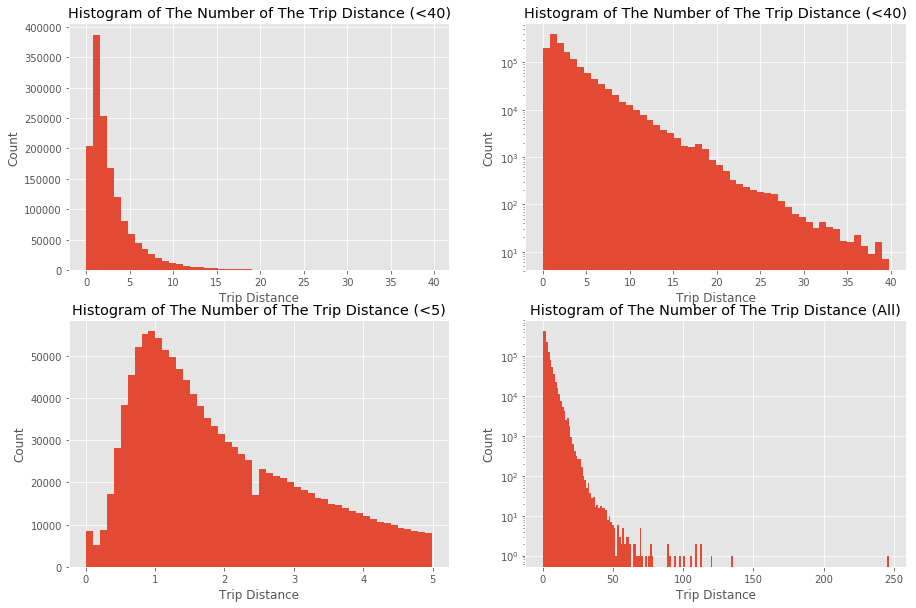

In [10]:
## To make the figures clear, let's only see the ones with trip distance < some threshold.
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (15,10))

data['Trip_distance'][data['Trip_distance'] < 40].hist(ax=ax1, bins=50)
ax1.set_title('Histogram of The Number of The Trip Distance (<40)')
ax1.set_xlabel('Trip Distance')
ax1.set_ylabel('Count')

data['Trip_distance'][data['Trip_distance'] < 40].hist(ax=ax2, bins=50)
ax2.set_yscale('log')
ax2.set_title('Histogram of The Number of The Trip Distance (<40)')
ax2.set_xlabel('Trip Distance')
ax2.set_ylabel('Count')


data['Trip_distance'][data['Trip_distance'] < 5].hist(ax=ax3, bins=50)
ax3.set_title('Histogram of The Number of The Trip Distance (<5)')
ax3.set_xlabel('Trip Distance')
ax3.set_ylabel('Count')

data['Trip_distance'].hist(ax=ax4, bins=200)
ax4.set_yscale('log')
ax4.set_title('Histogram of The Number of The Trip Distance (All)')
ax4.set_xlabel('Trip Distance')
ax4.set_ylabel('Count')

From the above figures, we can see that:

* When trip distance > 1, as the trip distance increases, its count decreases;

* when trip distance < 1, as the trip distance increases, its count increases.

In reality, it makes sense that most taxi trips are short trips（aruound 1-2 miles). Becuase for long trips, it would be expensive to take a taxi, and people probably would choose public transportations like metro or bus to save their money. While for short trips, people probably prefer to choose taxi to save their time.

__Hypotheses:__ 
* When 1 < trip distance < 40, the relation between trip distance (TD) and its log(count) is almost linear. In other words, we can represent it as `$TD = b - a*log(count)$`. 

#### Question 3(1)
• Report mean and median trip distance grouped by hour of day.

Text(0,0.5,'Trip Distance')

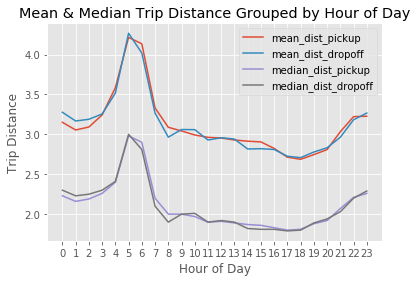

In [11]:
## There are only two variables are related to time in this dataset: 
## 'lpep_pickup_datetime' and 'Lpep_dropoff_datetime'.

## extract the hour of day from pickup datetime and dropoff datetime
data['pickup_hour'] = pd.DatetimeIndex(data['lpep_pickup_datetime']).hour
data['dropoff_hour'] = pd.DatetimeIndex(data['Lpep_dropoff_datetime']).hour

## group by hour, get the mean 
mean_dist_pickup = data['Trip_distance'].groupby(data['pickup_hour']).mean()
mean_dist_dropoff = data['Trip_distance'].groupby(data['dropoff_hour']).mean()

## group by hour, get the median
median_dist_pickup = data['Trip_distance'].groupby(data['pickup_hour']).median()
median_dist_dropoff = data['Trip_distance'].groupby(data['dropoff_hour']).median()

## create a dataframe to store them
df = pd.concat([mean_dist_pickup, mean_dist_dropoff,
                median_dist_pickup, median_dist_dropoff], axis=1)
df.columns = ['mean_dist_pickup', 'mean_dist_dropoff',
              'median_dist_pickup', 'median_dist_dropoff']


## visualize the dataframe
ax = df.plot(title='Mean & Median Trip Distance Grouped by Hour of Day')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best') 
ax.set_xticks(np.arange(24))
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Trip Distance")

From the above figure, we can see that 

* the trip distance grouped by hour of day calculated from pickup and dropoff are similar;

* the median trip distance is always lower than the mean trip distance;

* the mean and median trip distances have similar trends, and we can separate the time into three parts:
    * trip distance appears to be the longest during 4am-7am;
    * trip distance appears to be the shortest during 7am-9pm;
    * trip distance appears to be medium during 9pm-4am.

#### Question 3(2)
• We’d like to get a rough sense of identifying trips that originate or terminate at one of the NYC area airports. Can you provide a count of how many transactions fit this criteria, the average fare, and any other interesting characteristics of these trips.

In [12]:
# According to http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml,
# the initial charge is $2.50, so remove trips whose total amount < 2.5.
print('Removing trips whose total amount < $2.5  ...')
data = data[data['Total_amount'] > 2.5]
print('Remianing number of records:', data.shape[0])

Removing trips whose total amount < $2.5  ...
Remianing number of records: 1468752


In [13]:
## According to the document http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf
## RateCodeID 2 represents JFK Airport, and RateCodeID 3 represents Newark Airport

## Here I choose to only consider the trips originate or terminate at JFK Airport
print('Number of transactions of trips that originate or terminate at JFK Airport: %d.' 
      % data[data['RateCodeID']==2].shape[0])
print('The average fare amount of these transactions is: $%.2f.' 
      % data['Fare_amount'][data['RateCodeID']==2].mean())
print('The average total amount of these transactions is: $%.2f. \n' 
      % data['Total_amount'][data['RateCodeID']==2].mean())

Number of transactions of trips that originate or terminate at JFK Airport: 3414.
The average fare amount of these transactions is: $52.00.
The average total amount of these transactions is: $61.28. 



Fare amount:
52.0    3414
Name: Fare_amount, dtype: int64

Extra amount:
0.0    3414
Name: Extra, dtype: int64

MTA tax amount:
0.5    3405
0.0       9
Name: MTA_tax, dtype: int64

Improve_surcharge:
0.3    3401
0.0      13
Name: improvement_surcharge, dtype: int64


Text(0.5,1,'Tip Amount Distribution')

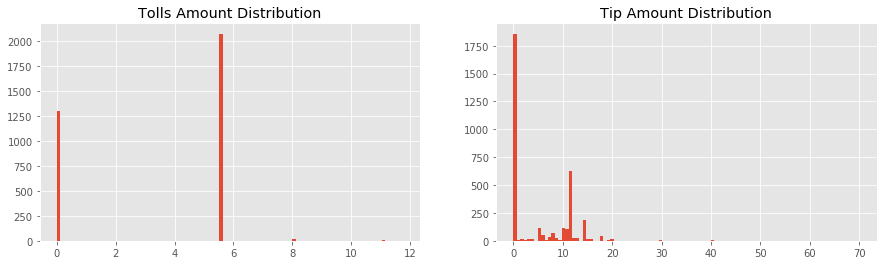

In [14]:
## Check the fare of JFK Airports
print('Fare amount:')
print(data['Fare_amount'][data['RateCodeID']==2].value_counts())

print('\nExtra amount:')
print(data['Extra'][data['RateCodeID']==2].value_counts())

print('\nMTA tax amount:')
print(data['MTA_tax'][data['RateCodeID']==2].value_counts())

print('\nImprove_surcharge:')
print(data['improvement_surcharge'][data['RateCodeID']==2].value_counts())

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,4))
data['Tolls_amount'][data['RateCodeID']==2].hist(ax=ax1, bins=100)
ax1.set_title('Tolls Amount Distribution')

data['Tip_amount'][data['RateCodeID']==2].hist(ax=ax2, bins=100)
ax2.set_title('Tip Amount Distribution')

_The fare amount of JFK trips is a fixed value: `$52`.
The main cause of different total amount is tolls amount and tip amount. 
Let's check whether the tip amount has something to do with the hour of a day._

Text(0,0.5,'Trip Count')

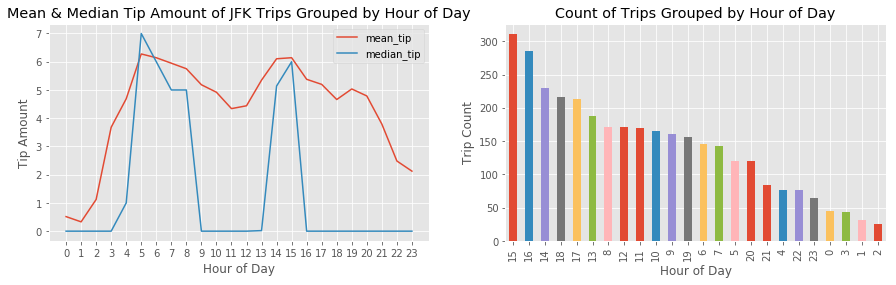

In [15]:
## Let's check whether the tip amount has something to do with the hour of a day.

## create a subset of JFK trips
df_jfk = data[data['RateCodeID']==2]

## Since most trips' pickup hour and dropoff hour are the same, we only use the pickup hour here.
## calculate the mean and median tip amount group by pickup hour of a day
mean_tip_jfk = df_jfk['Tip_amount'].groupby(df_jfk['pickup_hour']).mean()
median_tip_jfk = df_jfk['Tip_amount'].groupby(df_jfk['pickup_hour']).median()
mean_tip_jfk.name = 'mean_tip'
median_tip_jfk.name = 'median_tip'

## plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,4))
mean_tip_jfk.plot(ax=ax1)
median_tip_jfk.plot(ax=ax1)
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best') 
ax1.set_xticks(np.arange(24))
ax1.set_title("Mean & Median Tip Amount of JFK Trips Grouped by Hour of Day")
ax1.set_xlabel("Hour of Day")
ax1.set_ylabel("Tip Amount")

## plot
df_jfk['pickup_hour'].value_counts().plot.bar(ax=ax2)
ax2.set_title("Count of Trips Grouped by Hour of Day")
ax2.set_xlabel("Hour of Day")
ax2.set_ylabel("Trip Count")

From the above figure, we can conclude that the value of tip amount does have something to do with the hour of a day. 
* It is interesting that in most hours, the median of the tip amount is zero. 
* Both of the mean tip amount line and the median amount line show that one peak time of high tip amount is around 5:00-8:00, and the other peak time is around 14:00-15:00. From the right figure, we can see that 14:00-16:00 is the rush hour of a day. So, people probably give high tips because of heavy traffic. 

#### Question 4

• Build a derived variable for tip as a percentage of the total fare.

• Build a predictive model for tip as a percentage of the total fare. Use as much of the data as you like (or all of it). Provide an estimate of performance using an appropriate sample, and show your work.

Trip duration description (minutes):
min     0.000000
25%     0.105278
50%     0.175833
75%     0.289722
max    23.998333
Name: duration, dtype: float64
Remove trips whose duration > 5 hours and keep trips whose duration > 0 ...
Remaining number of records:  1460408


Text(0.5,0.98,'Histogram of Trip Duration (hour)')

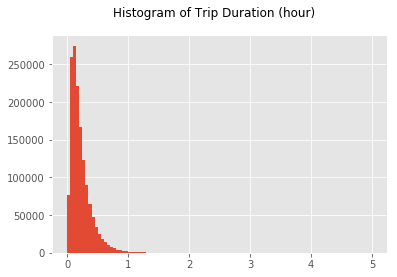

In [16]:
## Before building the model, let's create new features: trip duration and averge speed

## Create a new feature: trip duration
data['duration'] = pd.to_datetime(data['Lpep_dropoff_datetime']) - \
                    pd.to_datetime(data['lpep_pickup_datetime'])
data['duration'] = data['duration'] / np.timedelta64(1, 'h') # convert to minutes

print('Trip duration description (minutes):')
print(data['duration'].describe()[3:])

## it is abnormal that a trip's duration is more than 5 hours, so remove them
print('Remove trips whose duration > 5 hours and keep trips whose duration > 0 ...')
data = data[data['duration'] < 5]
data = data[data['duration'] > 0]
print('Remaining number of records: ', data.shape[0])

data['duration'].hist(bins=100)
plt.suptitle('Histogram of Trip Duration (hour)')

Define average speed over the course of a trip as Trip Distance/Trip Duration.
Average speed description (mph):
min         0.003503
25%         9.471658
50%        11.865169
75%        15.157895
max    202680.000000
Name: avg_speed, dtype: float64
Remove trips whose avg speed > 80 mph
Remaining number of records:  1457429


Text(0.5,0.98,'Histogram of Trip Average Speed (mph)')

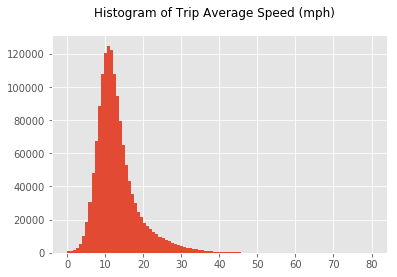

In [17]:
print('Define average speed over the course of a trip as Trip Distance/Trip Duration.')
data['avg_speed'] = data['Trip_distance']/data['duration']
print('Average speed description (mph):')
print(data['avg_speed'].describe()[3:])

# Remove trips whose avg speed > 80 mph
print('Remove trips whose avg speed > 80 mph')
data = data[data['avg_speed']<80]
print('Remaining number of records: ', data.shape[0])

data['avg_speed'].hist(bins=100)
plt.suptitle('Histogram of Trip Average Speed (mph)')

__According to the handbook, tip amount is automatically populated for credit card
tips. Cash tips are not included. Thus, for this question, I choose to only use the trips paid by credit card to build the predictive model.__

Text(0.5,0,'Payment (1=Credit card, 2=Cash, 3=No charge, 4=Dispute, 5=Unknown)')

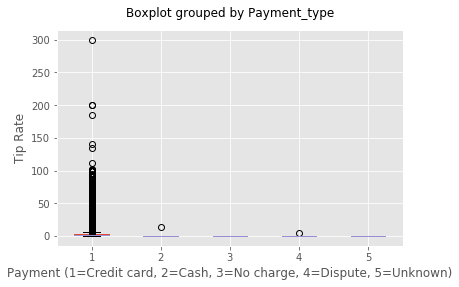

In [18]:
## check the relationship between payment type and tip
ax = plt.subplot()
data.boxplot('Tip_amount','Payment_type', ax=ax)
ax.set_title('')
ax.set_ylabel('Tip Rate')
ax.set_xlabel('Payment (1=Credit card, 2=Cash, 3=No charge, 4=Dispute, 5=Unknown)')

_From the figure above, we can see that the average tip amount of trips paid by credit card is bigger than zero, while others are zero. It makes sense since the tip amount is automatically populated for credit card tips, while cash tips are not included. So, let's only keep the trips paid by credit card._

In [19]:
# create a subset called df_tip with payment type = 1 (credit card)
print('Keep trips paid by credit card ...')
df_tip = data[data['Payment_type'] == 1]
print('Remianing number of records: ', df_tip.shape[0])

Keep trips paid by credit card ...
Remianing number of records:  687926


In [20]:
## Accoring to the handbook, fare amount is the time-and-distance fare calculated by the meter.
## Let's integrate other fare amount EXCEPT TIP AMOUNT into one variable called "other_amount".
df_tip['other_amount'] = df_tip['Extra'] + df_tip['MTA_tax'] + \
                         df_tip['Tolls_amount'] + df_tip['improvement_surcharge']
    
print('Other amount description ($):')
print(df_tip['other_amount'].describe()[3:])

Other amount description ($):
min     0.0
25%     0.8
50%     1.3
75%     1.3
max    75.0
Name: other_amount, dtype: float64


In [21]:
# create a variable "tip rate", that is, the percentage of tip amount over the total amount
print('Define tip rate as the percentage of tip amount over the total amount. \n')
df_tip['tip_rate'] = 100*df_tip['Tip_amount']/df_tip['Total_amount']
print('Tip rate description (%):')
print(df_tip['tip_rate'].describe()[3:])
print('\n')

# check the number of trips without tip
print('Number of trips with zero tips: ', df_tip[df_tip['tip_rate']==0].shape[0])
print('The percentage of trips with zero tips: ',
     round(100*df_tip[df_tip['tip_rate']==0].shape[0]/df_tip.shape[0],2), '%')

Define tip rate as the percentage of tip amount over the total amount. 

Tip rate description (%):
min      0.000000
25%     11.177347
50%     16.666667
75%     16.666667
max    100.000000
Name: tip_rate, dtype: float64


Number of trips with zero tips:  92347
The percentage of trips with zero tips:  13.42 %


_It is interesting that about 13.4% of trips' tip amount is zero in this subset._

Text(0.5,0,'Pickup Hour')

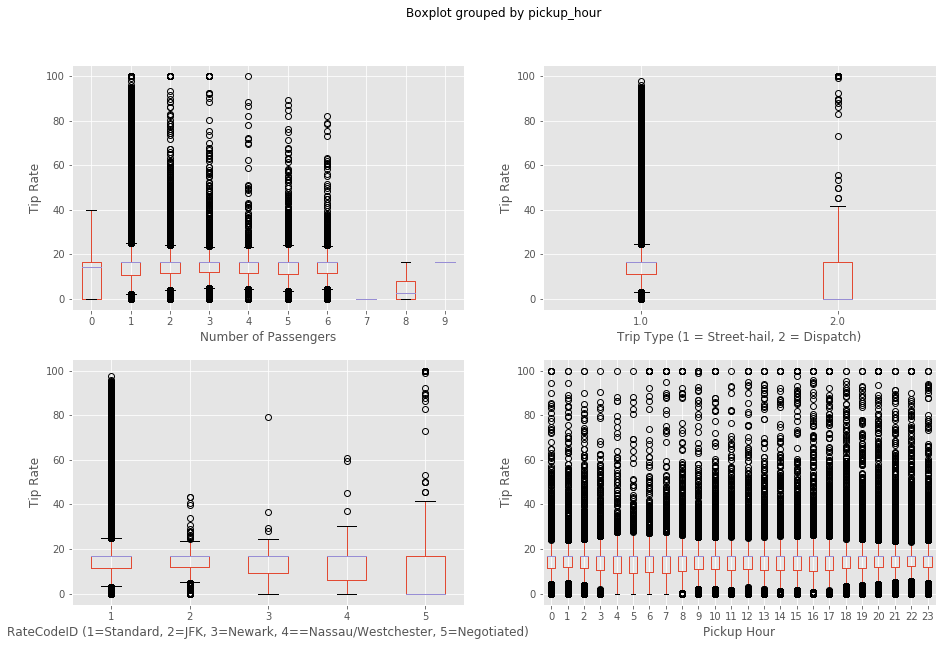

In [22]:
## More exploration about the relation between features and target
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(15,10))

df_tip.boxplot('tip_rate','Passenger_count', ax=ax1)
ax1.set_title('')
ax1.set_ylabel('Tip Rate')
ax1.set_xlabel('Number of Passengers')

df_tip.boxplot('tip_rate','Trip_type ', ax=ax2)
ax2.set_title('')
ax2.set_ylabel('Tip Rate')
ax2.set_xlabel('Trip Type (1 = Street-hail, 2 = Dispatch)')

df_tip.boxplot('tip_rate','RateCodeID', ax=ax3)
ax3.set_title('')
ax3.set_ylabel('Tip Rate')
ax3.set_xlabel('RateCodeID (1=Standard, 2=JFK, 3=Newark, 4==Nassau/Westchester, 5=Negotiated)')

df_tip.boxplot('tip_rate','pickup_hour', ax=ax4)
ax4.set_title('')
ax4.set_ylabel('Tip Rate')
ax4.set_xlabel('Pickup Hour')

_It seems that the tip rate distributions of 1 to 6 passengers are similar. However, for 7-9 passengers, the distributions change dramatically, and this is caused by not enough records.
According to the handbook, the number of passengers is a driver-entered value, and this explains why some values are zero since the driver did not enter it correctly. Since there is no strong evidence that the number of passengers effect tip rate, I am not going to use this feature for the following predictive model._

_It seems that street-hail trips tend to have higher tip rate than dispatch trips._

_It seems that standard trips and JFK trips have higher tip rate than others._

_It seems that pickup hour does effect trip rate._

Text(0.5,1,'Trip Rate vs Other Amount')

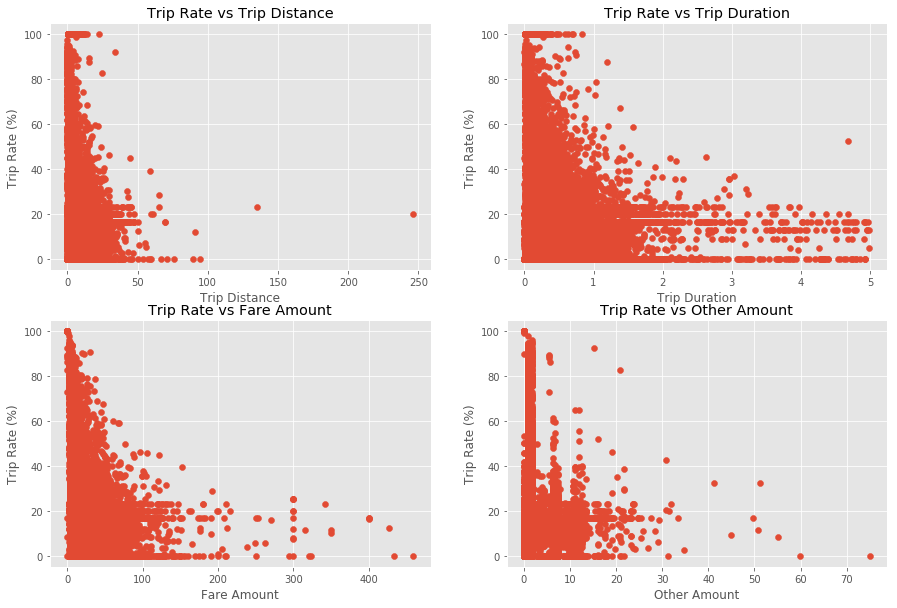

In [23]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(15,10))

ax1.scatter(df_tip['Trip_distance'], df_tip['tip_rate'])
ax1.set_xlabel('Trip Distance')
ax1.set_ylabel('Trip Rate (%)')
ax1.set_title('Trip Rate vs Trip Distance')

ax2.scatter(df_tip['duration'], df_tip['tip_rate'])
ax2.set_xlabel('Trip Duration')
ax2.set_ylabel('Trip Rate (%)')
ax2.set_title('Trip Rate vs Trip Duration')

ax3.scatter(df_tip['Fare_amount'], df_tip['tip_rate'])
ax3.set_xlabel('Fare Amount')
ax3.set_ylabel('Trip Rate (%)')
ax3.set_title('Trip Rate vs Fare Amount')

ax4.scatter(df_tip['other_amount'], df_tip['tip_rate'])
ax4.set_xlabel('Other Amount')
ax4.set_ylabel('Trip Rate (%)')
ax4.set_title('Trip Rate vs Other Amount')

### Build Model

In the following part, I will first build a linear regression model as a benchmark.
Then I will build a regression random forest model to see if we can get better results.

In [24]:
## Choose features

# numerical features
X_num = ['Trip_distance', 'duration','Fare_amount', 'other_amount', 'pickup_hour']

# one-hot encoding for categorical feature Trip_type
df_tip['trip_type_1'] = (df_tip['Trip_type '] == 1.0).astype(int)
df_tip['trip_type_2'] = (df_tip['Trip_type '] == 2.0).astype(int)

# one-hot encoding for categorical feature RateCodeID
df_tip['rate_code_1'] = (df_tip['RateCodeID'] == 1).astype(int)
df_tip['rate_code_2'] = (df_tip['RateCodeID'] == 2).astype(int)
df_tip['rate_code_3'] = (df_tip['RateCodeID'] == 3).astype(int)
df_tip['rate_code_4'] = (df_tip['RateCodeID'] == 4).astype(int)
df_tip['rate_code_5'] = (df_tip['RateCodeID'] == 5).astype(int)

# final categorical features
X_cat = ['trip_type_1', 'trip_type_2', 
         'rate_code_1', 'rate_code_2', 'rate_code_3', 'rate_code_4', 'rate_code_5']

### Linear Regression Model

In [25]:
# only use numerical features as X for linear regression model
X_lm = df_tip[X_num]

# target y
y = df_tip['tip_rate']

## Use the package "stats" since it provides p-values of coefficients automatically
import statsmodels.api as sm
from scipy import stats

est = sm.OLS(y, sm.add_constant(X_lm))
print(est.fit().summary())

                            OLS Regression Results                            
Dep. Variable:               tip_rate   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     671.0
Date:                Wed, 06 Jun 2018   Prob (F-statistic):               0.00
Time:                        13:13:46   Log-Likelihood:            -2.3482e+06
No. Observations:              687926   AIC:                         4.696e+06
Df Residuals:                  687920   BIC:                         4.696e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            14.6372      0.025    585.543

___The p-value of the variable of trip duration is too large (bigger than 0.05), so remove this variable and run the linear regression model again.___

In [26]:
## remove the column of trip duration and run the model again
X_lm = X_lm[['Trip_distance','Fare_amount','other_amount','pickup_hour']]
est2 = sm.OLS(y, sm.add_constant(X_lm))
print(est2.fit().summary())

                            OLS Regression Results                            
Dep. Variable:               tip_rate   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     838.2
Date:                Wed, 06 Jun 2018   Prob (F-statistic):               0.00
Time:                        13:13:46   Log-Likelihood:            -2.3482e+06
No. Observations:              687926   AIC:                         4.696e+06
Df Residuals:                  687921   BIC:                         4.696e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            14.6381      0.025    585.744

___Now all the p-values of all four variables' coefficients are statistically significant. Next, use the package "sklearn" to split the dataset into a training dataset and a test dataset (80% : 20%), and calculate the MAE and RMSE for them.___ 

Cross validation (10-fold) on the training dataset:
Mean Absolute Error (MAE): 5.44
Root Mean Squared Error (RMSE): 7.35


Results on the test dataset:
Mean Absolute Error (MAE): 5.42
Root Mean Squared Error (RMSE): 7.34


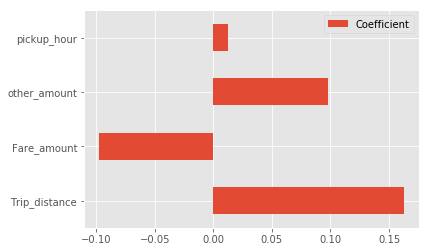

In [27]:
## Split data into a training dataset and a test dataset (8:2)
X_train, X_test, y_train, y_test = train_test_split(X_lm, y, test_size=0.2, random_state=0) 

## Linear Regression Model
lm = LinearRegression(normalize=True)
lm.fit(X_train, y_train) 

df_feat_impt = pd.DataFrame(lm.coef_, X_lm.columns, columns=['Coefficient'])
df_feat_impt.plot.barh()

## results on the training dataset
scores_MAE = cross_val_score(lm, X_lm, y, cv=10, scoring='mean_absolute_error')
scores_MSE = cross_val_score(lm, X_lm, y, cv=10, scoring='mean_squared_error')
print('Cross validation (10-fold) on the training dataset:')
print("Mean Absolute Error (MAE): %0.2f" % (-scores_MAE).mean())
print("Root Mean Squared Error (RMSE): %0.2f" % np.sqrt(-scores_MSE).mean())
print('\n')

## results on the test dataset
y_pred_test = lm.predict(X_test)

print('Results on the test dataset:')
print("Mean Absolute Error (MAE): %0.2f" %  metrics.mean_absolute_error(y_test, y_pred_test)) 
print("Root Mean Squared Error (RMSE): %0.2f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))  

* ___The training results calculated by 10-fold cross validation: MAE: 5.44, RMSE: 7.35.___

* ___The test results: MAE: 5.42, RMSE: 7.34.___

* ___Tip rate has a positive correlation with trip distance and other amount (total amount - tip amount - fare amount). Tip rate has a negative correlation with fare amount.___

* _We have already explored the relation between the tip rate and the hour of day, and we have found that their relation is not linear. It makes sense that the coefficient of the variable "pickup hour" is so close to zero._

### Regression Random Forest Model

Cross validation (5-fold) on the training dataset:
Mean Absolute Error (MAE): 5.40
Mean Squared Error (MSE): 7.20


Results on the test dataset:
Mean Absolute Error (MAE)5.37
Root Mean Squared Error (RMSE): 7.18


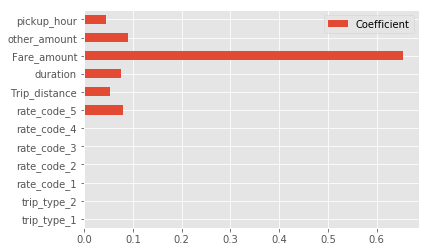

In [28]:
# use both numerical and categorical features as X for regression random forest model
X_feat = X_cat + X_num
X = df_tip[X_feat]

# target y
y = df_tip['tip_rate']

## Split data into a training dataset and a test dataset (8:2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

## Random Forest Regression Model
regressor = RandomForestRegressor(max_depth=8)  
regressor.fit(X_train, y_train) 

df_feat_impt = pd.DataFrame(regressor.feature_importances_, X.columns, columns=['Coefficient'])
df_feat_impt.plot.barh()

## results on the training dataset
from sklearn.model_selection import cross_val_score
scores_MAE = cross_val_score(regressor, X_train, y_train, cv=5, scoring='mean_absolute_error')
scores_MSE = cross_val_score(regressor, X_train, y_train, cv=5, scoring='mean_squared_error')
print('Cross validation (5-fold) on the training dataset:')
print("Mean Absolute Error (MAE): %0.2f" % (-scores_MAE).mean())
print("Mean Squared Error (MSE): %0.2f" % np.sqrt(-scores_MSE).mean())
print('\n')

## results on the test dataset
y_pred_test = regressor.predict(X_test)

print('Results on the test dataset:')
print("Mean Absolute Error (MAE)%0.2f" %  metrics.mean_absolute_error(y_test, y_pred_test)) 
print("Root Mean Squared Error (RMSE): %0.2f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))  

___The results of this random forest regression model are better than the ones of the linear regression model, since the root mean squared errors (RMSE) and the mean absolute errors (MAE) are slightly lower than the ones of the linear regression model. So, we should use this model to predict the tip rate of trips.___

* ___The training results calculated by 10-fold cross validation: MAE: 5.40, RMSE: 7.20.___

* ___The test results: MAE: 5.37, RMSE: 7.18.___

* ___Fare amount and other amount are the top 2 features affect tip rate in this regression random forest model, and this correspond with the results of the linear regression model.___

* ___Duration, trip distance, and pickup hour also affect the trip rate.___

* _It is interesting that negotiated trips (RodeCodeID=5) affect tip rate._

#### Question 5: Option A: Distributions

• Build a derived variable representing the average speed over the course of a trip.

___At the beginning of question 4, We have already deefined average speed over the course of a trip as Trip Distance/Trip Duration, and its unit is mile per hour (mph).___

#### Question 5A(2):
• Can you perform a test to determine if the average trip speeds are materially the same in all weeks of September? If you decide they are not the same, can you form a hypothesis regarding why they differ?

In [29]:
# create the variable "week" extracted from trip datetime
data['week'] = pd.DatetimeIndex(data['lpep_pickup_datetime']).week
print("Count of trips in each week:")
print(data['week'].value_counts())

Count of trips in each week:
37    354963
38    350734
39    330262
36    292763
40    128707
Name: week, dtype: int64


* Week 36: 292718 trips, 6 days (Sep.1 - Sep.6, Tus-Sun)
* Week 37: 354859 trips, 7 days  
* Week 38: 350635 trips, 7 days 
* Week 39: 330163 trips, 7 days 
* Week 40: 128667 trips, 3 days (Sep.28 - Sep.30, Mon-Wes)

Text(0.5,1,'Density Plot of Average Speed in Each Week')

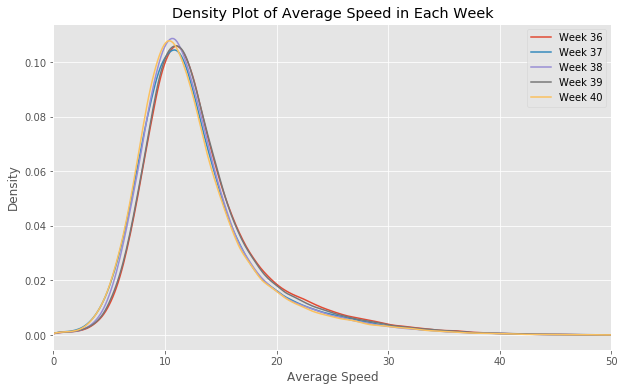

In [30]:
# draw density plot of avg speed of each week
fig, ax = plt.subplots(1,1,figsize=(10,6))
data['avg_speed'][data['week']==36].plot.kde()
data['avg_speed'][data['week']==37].plot.kde()
data['avg_speed'][data['week']==38].plot.kde()
data['avg_speed'][data['week']==39].plot.kde()
data['avg_speed'][data['week']==40].plot.kde()

lines = ax.get_legend_handles_labels()[0]
labels = ['Week 36', 'Week 37', 'Week 38', 'Week 39', 'Week 40']
ax.legend(lines, labels, loc='best') 
ax.set_xlim([0,50])
ax.set_xlabel("Average Speed")
ax.set_ylabel("Density")
ax.set_title("Density Plot of Average Speed in Each Week")

_From the above figure, we can see that the average trip speeds of week 37, week 38 and week 40 are slightly slower than the ones of week 36 and week 39. Next, I will perform an ANOVA test to see if the polulation mean of the average trip speed of these five weeks are the same._

_Note: From the above figure, we can see that the distributions of the average trip speed are not normal distributions. However, the sample size of each group (each week) is big enough so that we can use ANOVA tests in this case._

In [31]:
## Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html

## The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean. 
## The test is applied to samples from two or more groups, possibly with differing sizes.

from scipy.stats import f_oneway

print('ANOVA test:')
print(stats.f_oneway(data['avg_speed'][data['week']==36],
                     data['avg_speed'][data['week']==37],
                     data['avg_speed'][data['week']==38],
                     data['avg_speed'][data['week']==39],
                     data['avg_speed'][data['week']==40]))

print("Mean average speed of week 36: %0.2f mph" % data['avg_speed'][data['week']==36].mean())
print("Mean average speed of week 37: %0.2f mph" % data['avg_speed'][data['week']==37].mean())
print("Mean average speed of week 38: %0.2f mph" % data['avg_speed'][data['week']==38].mean())
print("Mean average speed of week 39: %0.2f mph" % data['avg_speed'][data['week']==39].mean())
print("Mean average speed of week 40: %0.2f mph" % data['avg_speed'][data['week']==40].mean())

ANOVA test:
F_onewayResult(statistic=964.4549411680998, pvalue=0.0)
Mean average speed of week 36: 13.47 mph
Mean average speed of week 37: 12.84 mph
Mean average speed of week 38: 12.86 mph
Mean average speed of week 39: 13.34 mph
Mean average speed of week 40: 12.66 mph


_The ANOVA test shows that the p-value is very small and the statistic is very large. Thus, the polulation mean of the average trip speed of these five weeks are significantly not the same._

_I checked [NYC historical weather in September 2015](https://www.timeanddate.com/weather/usa/new-york/historic?month=9&year=2015) and found that  it was raining on Sep.10th (in week 37) and Sep.30th (in week 40). This probably explains the reason why the average trip speeds in week 37 and week 40 are slightly slower than the ones in week 36 and week 39. I do not find any reasonable explanations why the average trip speed in week 38 is slow._

#### Question 5A(3)
* Can you build up a hypothesis of average trip speed as a function of time of day?

Text(0.5,1,'Average Speed of Time of Day')

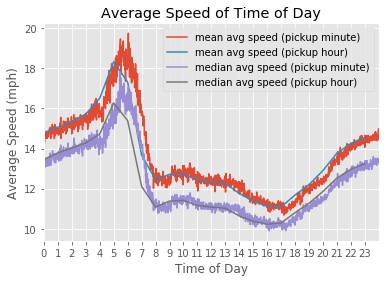

In [32]:
# create the variable "pickup time" extracted from trip pickup datetime,
# only use "hour" and "minute", not "second"
data['pickup_time'] = pd.DatetimeIndex(data['lpep_pickup_datetime']).hour + \
                      pd.DatetimeIndex(data['lpep_pickup_datetime']).minute/60

ax = plt.subplot()

data['avg_speed'].groupby(data['pickup_time']).mean().plot()
data['avg_speed'].groupby(data['pickup_hour']).mean().plot()
data['avg_speed'].groupby(data['pickup_time']).median().plot()
data['avg_speed'].groupby(data['pickup_hour']).median().plot()

lines = ax.get_legend_handles_labels()[0]
labels = ['mean avg speed (pickup minute)', 'mean avg speed (pickup hour)',
         'median avg speed (pickup minute)', 'median avg speed (pickup hour)']
ax.legend(lines, labels, loc='best') 

ax.set_xlim([0,24])
ax.set_xticks(np.arange(24))
ax.set_xlabel("Time of Day")
ax.set_ylabel("Average Speed (mph)")
ax.set_title("Average Speed of Time of Day")

_Hypothesis: The average trip speed during 21:00 - 7:00 is higher than the one during 7:00 - 21:00._

_We can use t-test to prove this._

In [33]:
from scipy.stats import ttest_ind

hour_7to21 = data[data['pickup_time'] >= 7]
hour_7to21 = hour_7to21[hour_7to21['pickup_time'] <= 21]

hour_21to7 = pd.concat([data[data['pickup_time'] >= 21], data[data['pickup_time'] <= 7]])

print('Two-sample t-test for average speed during  7:00 - 21:00 and  21:00 - 7:00.')
print(ttest_ind(hour_7to21['avg_speed'], hour_21to7['avg_speed']))

Two-sample t-test for average speed during  7:00 - 21:00 and  21:00 - 7:00.
Ttest_indResult(statistic=-289.9557911497183, pvalue=0.0)


_The p-value is zero, and the absolute t-statistic value is very large. This indicates that the average trip speed during 7:00 - 21:00 and the one during 21:00 - 7:00 are significantly different._